# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd

In [2]:
# Загрузка данных (путь к файлу указан /datasets/real_estate_data.csv)
#df = pd.read_csv('/datasets/real_estate_data.csv')
#data.info()

In [3]:
# Данные загрузились некорректно: все колонки записаны в один столбец в виде строки. 
# Попробуем загрузить файл с разделителем табуляцией.

In [4]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [40]:
# Выведим несколько строк из таблицы на экран.
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_m,exposition_weekday,exposition_month,exposition_year,floor_type,cityCenters_nearest_km,floor_type_encoded
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,2.0,755.0,NaN,120370.37,3,3,2019,другой,16,1
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,NaN,81.0,82920.79,1,12,2018,первый,19,0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,2.0,574.0,558.0,92785.71,3,8,2015,другой,14,1
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.212766,9,False,...,3.0,234.0,424.0,408176.10,4,7,2015,другой,7,1
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,1.0,48.0,121.0,100000.00,1,6,2018,другой,8,1


Замечания по пропущенным значениям:
ceiling_height (высота потолков) – много пропусков (14504 из 23699 заполнено). 
is_apartment – очень много пропусков (2775 из 23699 заполнено). 
balcony – 11519 пропущенных значений.
airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest – пропуски.
days_exposition (дней продажи) – 3181 пропущенное значение. 

Замечания по форматам данных:
first_day_exposition – тип даных (object), лучше привести к datetime
floors_total – тип даных (float64), хотя этажи - целые числа (Int64). 

### Выполните предобработку данных

In [6]:
# Поишем аномалии в колонке высоты потолков (ceiling_height) 
print(data['ceiling_height'].describe()) 

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


Минимум: 1.0 м (потолок в 1 м - явно что это ошибка)
Максимум: 100 м (явно ошибка, аномально большое значение)
Стандартное отклонение: 1.26 — довольно высокое, это говорит нам о разбросе данных.
В случае высоты потолков (ceiling_height) лучше будем использовать медианное значение, а не среднее.
Медиана устойчива к выбросам и лучше отражает типичное значение, а в данных могут быть аномальные выбросы.

In [7]:
# В колонке (ceiling_height) значения < 2,5 м и > 5 м считаем выбросами (бывают петхаусы с потолком 5 м)

# Заменяем значения < 2,5 м и > 5 м на NaN (чтобы потом их учесть при заполнении медианой).
data.loc[(data['ceiling_height'] < 2.5) | (data['ceiling_height'] > 5), 'ceiling_height'] = None 

# Пересчитываем медиану после очистки и удаления аномалий.
median_ceiling = data['ceiling_height'].median()

# Заполняем пропущенные значения новой медианой.
data['ceiling_height'].fillna(median_ceiling, inplace=True)  

# Проверим наш результат после обработки
print(data['ceiling_height'].describe())  

count    23699.000000
mean         2.696927
std          0.214529
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64


Теперь данные по высоте потолков выглядят более реалистично
Медиана (50%) = 2.65 м, cреднее ≈ 2.70 м (близко к медиане, значит, выбросов больше нет)
Стандартное отклонение стало 0.21 (раньше было 1.26, то есть разброс уменьшился)

In [8]:
# Предположим, что в (balcony) пропуски означают отсутствие балкона, заменим на 0.
data['balcony'].fillna(0, inplace=True) 

In [9]:
# Поишем аномалии в ценах на квартиры (last_price) 
print(data['last_price'].describe())

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


Минимальная цена: 12 190 рублей — для квартиры это слишком мало, скорее всего, ошибка.
Максимальная цена: 763 000 000 рублей (763 млн) — это может быть элитное жилье.

In [10]:
# Уберем экстремально дешевые квартиры, оставим реалистичные значения.
# Фильтруем слишком низкие цены (явные ошибки)
data = data[data['last_price'] >= 100000]

# Проверим результат 
print(data['last_price'].describe())

count    2.369800e+04
mean     6.541824e+06
std      1.088716e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


После фильтрации минимальная цена составляет 430,000, что вполне соответствует реалистичным значениям для рынка недвижимости.
Средняя цена квартиры (mean) составляет 6,541,824, а медиана (50-й процентиль) — 4,650,000. Это говорит о том, что большинство квартир находятся в диапазоне от 3.4 млн до 6.8 млн, при этом присутствуют высокие выбросы, так как максимальная цена достигает 763 млн.
Стандартное отклонение (std) достаточно высокое, что подтверждает наличие значительных ценовых вариаций.

In [11]:
# Поишем аномалии в общей площади квартир (total_area) 
print(data['total_area'].describe())

count    23698.000000
mean        60.346598
std         35.653434
min         12.000000
25%         40.000000
50%         52.000000
75%         69.875000
max        900.000000
Name: total_area, dtype: float64


Минимальная площадь: 12 м² — это маловато.
Максимальная площадь: 900 м² — это многократно больше стандартного жилья, возможно ошибка.
Средняя площадь: 60.35 м² — похоже на реальную среднюю квартиру.

In [12]:
# Фильтруем подозрительно большие квартиры (берем 99-й перцентиль)
upper_area_limit = data['total_area'].quantile(0.99)
data = data[data['total_area'] <= upper_area_limit]

# Проверяем результат
print(data['total_area'].describe())

count    23461.000000
mean        58.117608
std         26.376200
min         12.000000
25%         40.000000
50%         51.800000
75%         68.850000
max        197.200000
Name: total_area, dtype: float64


Убрали экстремально большие квартиры, оставили реалистичные значения.
После фильтрации минимальная площадь составляет 12 кв. м., что является вполне реалистичной для небольших квартир.
Средняя площадь квартиры (mean) составляет 58.12 кв. м., медиана (50-й процентиль) — 51.8 кв. м., что свидетельствует о том, что большинство квартир имеют площадь в пределах 40-69 кв. м.
Стандартное отклонение (std) равно 26.38 кв. м., что также подтверждает наличие значительных вариаций в площади квартир.
Максимальная площадь после фильтрации составляет 197.2 кв. м., что все еще является достаточно большой площадью, но уже находится в пределах нормальных значений для квартир в крупных городах.

Пропущенных значений в (is_apartment) очень много (более 20 000 из 23 699 записей).
Скорее всего, пропуски означают, что это обычные квартиры (а не апартаменты).

In [13]:
# Поменяем формат данных. Заменим NaN в (is_apartment) на False и приведем к типу bool.
data['is_apartment'].fillna(False, inplace=True)
data['is_apartment'] = data['is_apartment'].astype(bool)

In [14]:
# Поменяем формат данных. Приведем (first_day_exposition) к типу datetime. 
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [15]:
# Поменяем формат данных.
# Колонка (floors_total) имеет тип float64, хотя этажи обычно целые числа. Преобразуем в int64
data['floors_total'] = data['floors_total'].astype('Int64')

In [16]:
# Проведем проверку на оставшиеся пропущенные значения.
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area              1872
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2247
balcony                     0
locality_name              49
airports_nearest         5535
cityCenters_nearest      5515
parks_around3000         5514
parks_nearest           15537
ponds_around3000         5514
ponds_nearest           14517
days_exposition          3128
dtype: int64


Наибольшее количество пропусков наблюдается в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest и days_exposition. Эти столбцы имеют от нескольких тысяч пропусков до десятков тысяч. Пропуски в этих столбцах могут быть связаны с данными о расстояниях до объектов инфраструктуры, которые могут быть не указаны для всех объектов недвижимости.
Пропуски в столбце living_area (1872 пропуска) также значимы, так как они могут касаться важного параметра для расчета стоимости жилья.
Столбцы, такие как total_images, last_price, total_area, first_day_exposition, rooms, и ceiling_height, не содержат пропусков, что является хорошим показателем качества данных по этим параметрам.

In [17]:
# В колонке living_area (жилая площадь) 1823 пропуска
# Рассчитаем медианное соотношение living_area / total_area и заполним по нему:
median_ratio = (data['living_area'] / data['total_area']).median()
data['living_area'].fillna(data['total_area'] * median_ratio, inplace=True)

In [18]:
# В колонке floors_total (количество этажей) есть 84 пропуска, заполним их медианой
data['floors_total'].fillna(data['floors_total'].median(), inplace=True)

In [19]:
# код ревьюера
display(data[data['floors_total'] < data['floor']].shape[0])

37

In [20]:
# Удаляем строки, где этаж больше, чем общее количество этажей в доме
data = data[data['floor'] <= data['floors_total']]

# Проверяем, что проблема устранена, должно быть 0
print(data[data['floors_total'] < data['floor']].shape[0])

0


In [21]:
# В колонке kitchen_area (площадь кухни) есть 2204 пропуска
# Аналогично отношению жилая/общая площадь — найдем медианное соотношение и заполним
median_ratio = (data['kitchen_area'] / data['total_area']).median()
data['kitchen_area'].fillna(data['total_area'] * median_ratio, inplace=True)

In [22]:
# Устраним неявные дубликаты в названиях населённых пунктов
# Приводим к нижнему регистру и убираем лишние пробелы
data['locality_name'] = data['locality_name'].str.strip().str.lower()

# Смотрим уникальные названия (топ 50)
print(data['locality_name'].value_counts().head(50))

санкт-петербург                            15469
посёлок мурино                               520
посёлок шушары                               439
всеволожск                                   398
пушкин                                       364
колпино                                      337
посёлок парголово                            326
гатчина                                      307
деревня кудрово                              299
выборг                                       237
петергоф                                     200
сестрорецк                                   182
красное село                                 176
кудрово                                      171
деревня новое девяткино                      143
сертолово                                    141
ломоносов                                    133
кириши                                       125
сланцы                                       112
волхов                                       111
тосно               

Есть неявные дубликаты, например:
"посёлок мурино", "мурино", "поселок мурино" - похоже что это одно и то же место.
"поселок бугры", "посёлок бугры" - разная форма написания одного и того же места.
"городской посёлок янино-1", "посёлок городского типа янино-1" - схожие названия одного и того же места.

In [23]:
# Количество уникальных значений до обработки
unique_localities_before = data['locality_name'].nunique()
print(f"До обработки: {unique_localities_before} уникальных значений")

До обработки: 363 уникальных значений


In [24]:
# Создадим словарь для замены неявных дубликатов
locality_corrections = {
    'мурино': 'посёлок мурино',
    'поселок мурино': 'посёлок мурино',
    'поселок бугры': 'посёлок бугры',
    'городской посёлок янино-1': 'посёлок янино-1',
    'посёлок городского типа янино-1': 'посёлок янино-1',
}

# Применим замену
data['locality_name'] = data['locality_name'].replace(locality_corrections)

# Проверяем результат
print(data['locality_name'].value_counts().head(50))


санкт-петербург                            15469
посёлок мурино                               588
посёлок шушары                               439
всеволожск                                   398
пушкин                                       364
колпино                                      337
посёлок парголово                            326
гатчина                                      307
деревня кудрово                              299
выборг                                       237
петергоф                                     200
сестрорецк                                   182
красное село                                 176
кудрово                                      171
деревня новое девяткино                      143
сертолово                                    141
ломоносов                                    133
кириши                                       125
посёлок бугры                                114
сланцы                                       112
волхов              

Теперь неявные дубликаты устранены

✔  Комментарий принял к выполнению.
Дополнительно сравним количество уникальных значений до обработки названий населенных пунктов и после, чтобы увидеть результат проведенной работы.

In [25]:
# Количество уникальных значений после обработки
unique_localities_after = data['locality_name'].nunique()

# Выводим разницу
print(f"После обработки: {unique_localities_after} уникальных значений")
print(f"Сократилось на {unique_localities_before - unique_localities_after} значения")


После обработки: 360 уникальных значений
Сократилось на 3 значения


Комментарий в работу!

In [26]:
# Подсчёт количества полных дубликатов
duplicate_rows = data.duplicated(keep=False).sum()
print(f"Количество полных дубликатов: {duplicate_rows}")

Количество полных дубликатов: 0


Как видим в данных нет полных дубликатов.

В перечиленных колонках оставим пропуски - все это геоданные:
airports_nearest 
cityCenters_nearest 
parks_around3000
parks_nearest
ponds_around3000 
ponds_nearest

### Добавьте в таблицу новые столбцы

Добавим в таблицу новые параметры:
- цена одного квадратного метра;
- день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах.

In [27]:
# Цена одного квадратного метра (округление до 2 знаков после запятой)
data['price_per_sq_m'] = (data['last_price'] / data['total_area']).round(2)

# День, месяц и год публикации объявления
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday  # 0 - понедельник, 6 - воскресенье
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

# Тип этажа квартиры
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(floor_category, axis=1) 

# Расстояние до центра города в километрах (округление до целых)
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0).astype('Int64')

# Проверяем результат
print(data[['price_per_sq_m', 'exposition_weekday', 'exposition_month', 'exposition_year', 'floor_type', 'cityCenters_nearest_km']].head())

   price_per_sq_m  exposition_weekday  exposition_month  exposition_year  \
0       120370.37                   3                 3             2019   
1        82920.79                   1                12             2018   
2        92785.71                   3                 8             2015   
3       408176.10                   4                 7             2015   
4       100000.00                   1                 6             2018   

  floor_type  cityCenters_nearest_km  
0     другой                      16  
1     первый                      19  
2     другой                      14  
3     другой                       7  
4     другой                       8  


На основе добавленных новых параметров можно сделать следующий промежуточный вывод:

Цена одного квадратного метра:

Новый столбец price_per_sq_m позволяет увидеть стоимость одного квадратного метра для каждой квартиры. Это полезный показатель для анализа цен на недвижимость и сравнений между различными объектами. Все значения округлены до одного знака после запятой.

День, месяц и год публикации объявления:

Были добавлены столбцы, отражающие день недели (exposition_weekday), месяц (exposition_month) и год (exposition_year) публикации объявления. Эти данные могут быть нам полезны для анализа сезонности и временных факторов, влияющих на цены.

Тип этажа квартиры:

Введен новый столбец floor_type, который определяет, на каком этаже находится квартира:
«первый» — для первого этажа;
«последний» — для последнего этажа;
«другой» — для всех остальных этажей.
Это разделение может быть полезным для дальнейшего анализа влияния этажа на цену квартиры.

Расстояние до центра города:

В столбец cityCenters_nearest_km добавлены значения расстояния до центра города в километрах. Это расстояние было преобразовано из метрик в километры и округлено до одного знака после запятой.
Этот параметр может быть полезен для анализа зависимости цен на квартиры от их удаленности от центральных районов города.

Все дополнительные параметры обеспечивают более глубокое понимание различных факторов, влияющих на стоимость недвижимости.

### Проведите исследовательский анализ данных

In [28]:
# Выведем такие показатели, как среднее, медиана, стандартное отклонение, минимальные и максимальные значения.
columns_to_describe = [
    'total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 
    'ceiling_height', 'floors_total', 'cityCenters_nearest', 'parks_nearest'
]

print(data[columns_to_describe].describe())

         total_area   living_area  kitchen_area    last_price         rooms  \
count  23424.000000  23424.000000  23424.000000  2.342400e+04  23424.000000   
mean      58.116647     33.258649     10.268339  6.017044e+06      2.033897   
std       26.379223     17.210373      5.323707  6.220896e+06      0.994479   
min       12.000000      2.000000      1.300000  4.300000e+05      0.000000   
25%       40.000000     19.000000      7.000000  3.400000e+06      1.000000   
50%       51.800000     30.000000      9.000000  4.600000e+06      2.000000   
75%       68.812500     42.000000     11.800000  6.700000e+06      3.000000   
max      197.200000    164.700000     93.200000  3.300000e+08     11.000000   

       ceiling_height  floors_total  cityCenters_nearest  parks_nearest  
count    23424.000000  23424.000000         17916.000000    7915.000000  
mean         2.692866     10.710681         14280.776122     491.851421  
std          0.205631      6.598727          8598.741413     343.1

Данные показывают большое разнообразие объектов недвижимости, что характерно для рынка недвижимости с различными типами жилья, ценами, площадями и расположением.

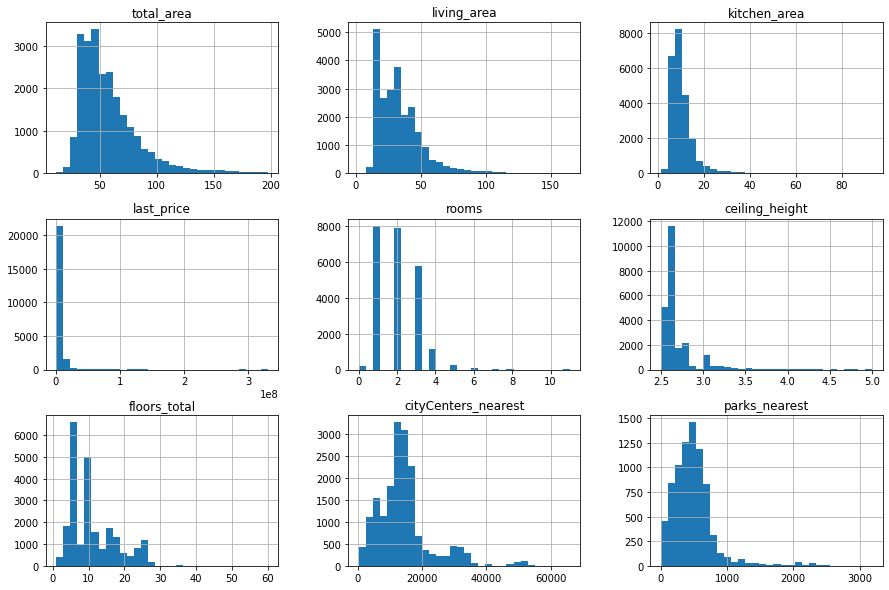

In [29]:
# Анализ распределений (гистограммы), оценим визуально распределение данных.
import matplotlib.pyplot as plt

data[columns_to_describe].hist(figsize=(15, 10), bins=30)
plt.show()

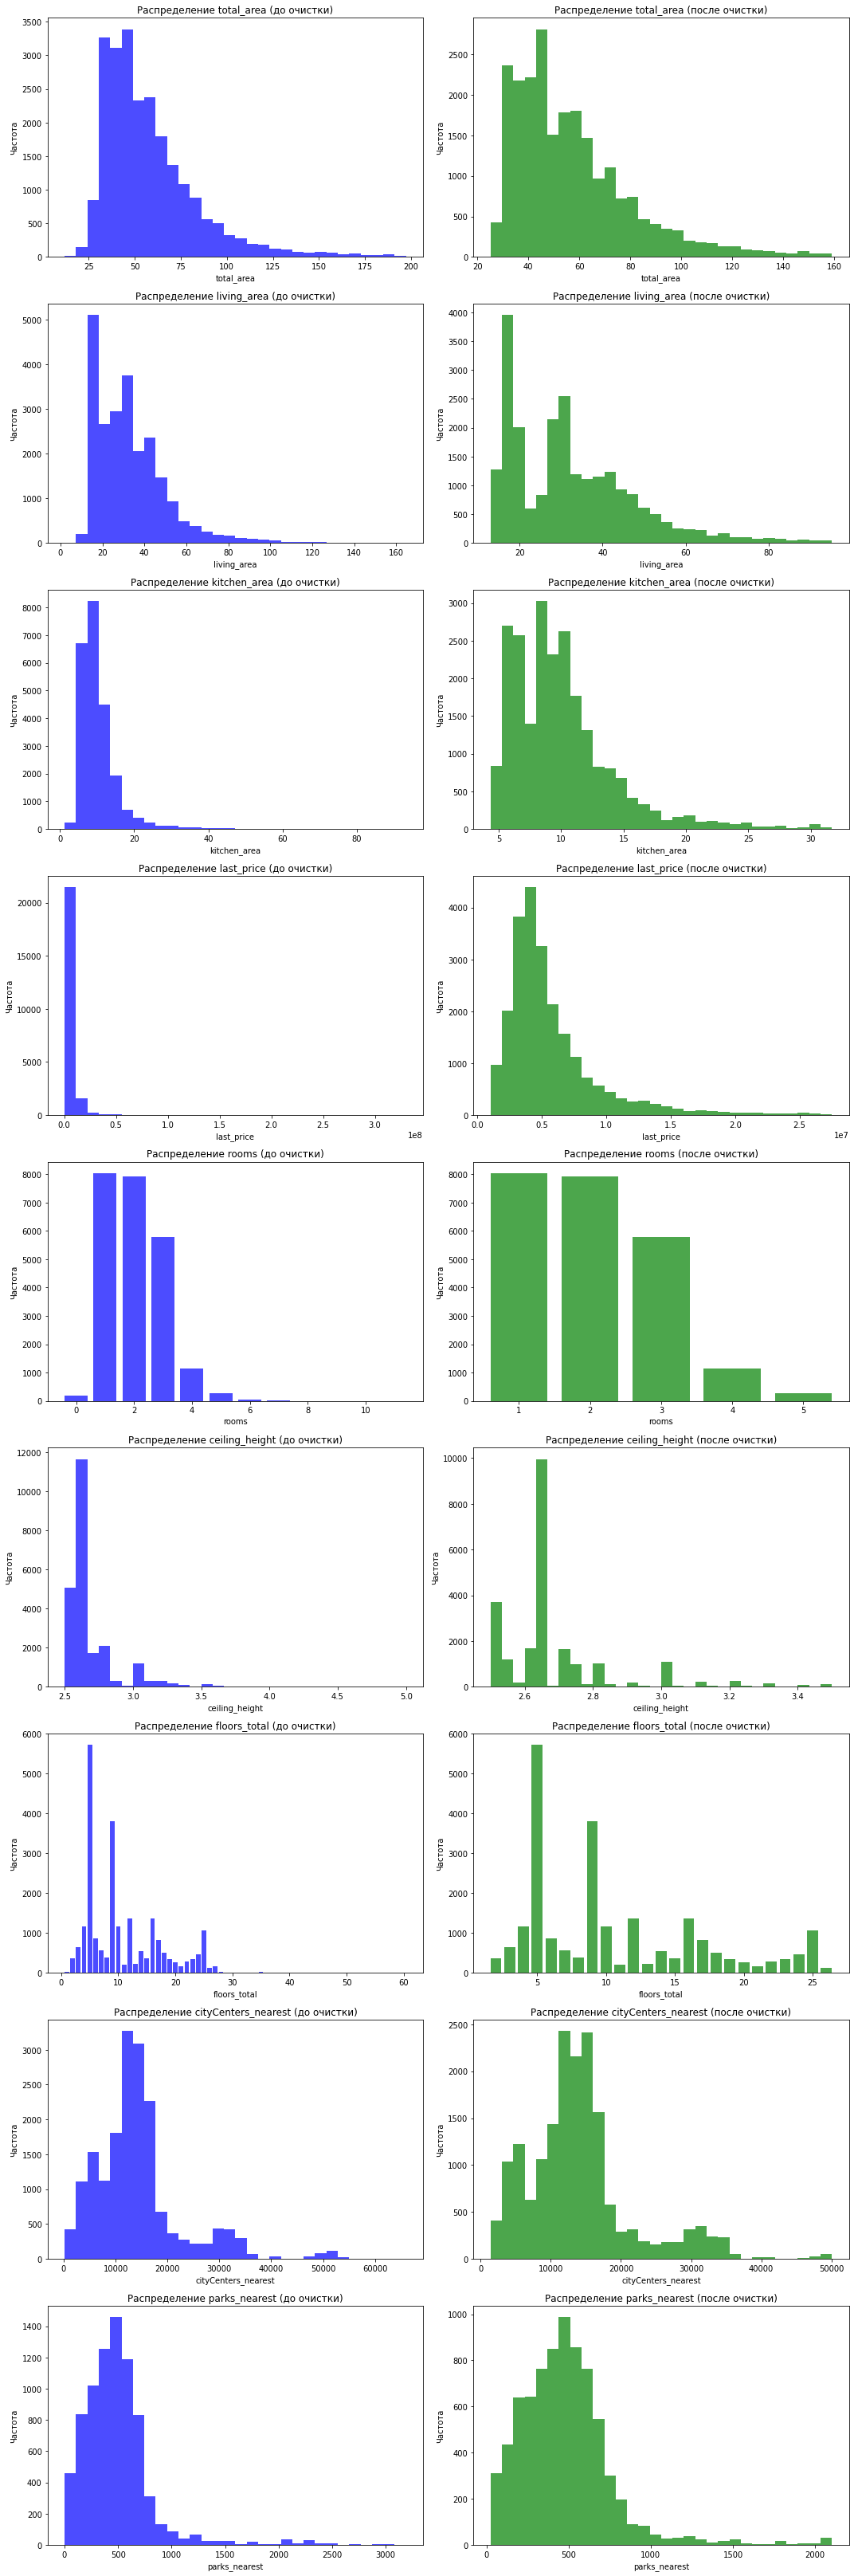

In [30]:
# Определяем параметры для анализа
columns_to_describe = [
    'total_area', 'living_area', 'kitchen_area', 'last_price', 
    'rooms', 'ceiling_height', 'floors_total', 'cityCenters_nearest', 'parks_nearest'
]

# Определяем, какие переменные дискретные
discrete_columns = ['rooms', 'floors_total']  # Категориальные данные, лучше bar plot
continuous_columns = list(set(columns_to_describe) - set(discrete_columns))  # Остальные

# Создаем графики: два столбца, по два графика на каждый параметр
fig, axes = plt.subplots(len(columns_to_describe), 2, figsize=(15, 5 * len(columns_to_describe)))

for i, column in enumerate(columns_to_describe):
    if column in discrete_columns:
        # Столбчатая диаграмма (bar plot) для дискретных данных
        value_counts = data[column].value_counts().sort_index()
        axes[i, 0].bar(value_counts.index, value_counts.values, color='blue', alpha=0.7)
        axes[i, 0].set_title(f'Распределение {column} (до очистки)')
        axes[i, 0].set_xlabel(column)
        axes[i, 0].set_ylabel('Частота')

        # Исключаем редкие значения (например, ниже 1-го и выше 99-го процентиля)
        filtered_data = data[(data[column] >= data[column].quantile(0.01)) & 
                             (data[column] <= data[column].quantile(0.99))]
        value_counts_filtered = filtered_data[column].value_counts().sort_index()

        axes[i, 1].bar(value_counts_filtered.index, value_counts_filtered.values, color='green', alpha=0.7)
        axes[i, 1].set_title(f'Распределение {column} (после очистки)')
        axes[i, 1].set_xlabel(column)
        axes[i, 1].set_ylabel('Частота')

    else:
        # Гистограмма (hist) для непрерывных данных
        axes[i, 0].hist(data[column], bins=30, color='blue', alpha=0.7)
        axes[i, 0].set_title(f'Распределение {column} (до очистки)')
        axes[i, 0].set_xlabel(column)
        axes[i, 0].set_ylabel('Частота')

        # Исключаем выбросы (1-й и 99-й процентили)
        lower_bound, upper_bound = data[column].quantile([0.01, 0.99])
        filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

        axes[i, 1].hist(filtered_data[column], bins=30, color='green', alpha=0.7)
        axes[i, 1].set_title(f'Распределение {column} (после очистки)')
        axes[i, 1].set_xlabel(column)
        axes[i, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()


Вывод: 

Большинство квартир среднего размера с жилой площадью (50–60 м²), в основном до 100 м². Доля жилой площади составляет примерно 57% от общей площади. Тем не менее есть редкие крупные квартиры. Большинство кухонь 7–12 м². Есть выбросы 40+ м², вероятно это элитные квартиры.

Основная масса объектов до 10 млн рублей. Средняя цена: 6 млн рублей. Длинный хвост до 300 млн - это редкие элитные квартиры. 

По количеству комнат - большинство квартир 1–3-комнатные.

В основном стандартные потолки высотой 2.6–2.7 м. Выбросы 4+ м (лофты, старый фонд).

Большинство домов 5–16 этажей: 5-этажные (старый фонд) и 9-16 этажей (новостройки). 

Большая часть квартир в пределах 15 км от центра. Длинный хвост до 60 км - это загородная недвижимость.

Основная масса до 1 км до парка. Длинный хвост до 3 км → районы в дали от парков.

Заключение:

Данные имеют сильную асимметрию, особенно по цене, площади и расстоянию.
Большинство квартир: 2-3 комнаты, 50-60 м², кухня около 10 м², в 10-20 км от центра. Разброс цен большой.

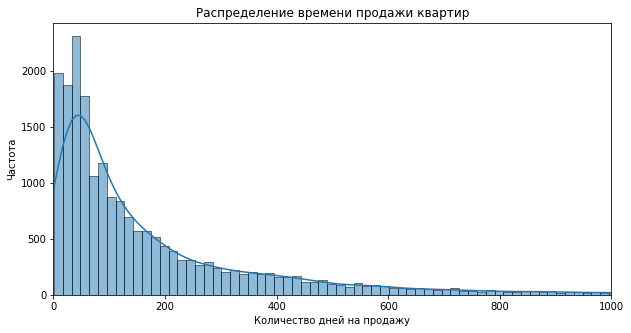

In [31]:
# Анализ скорости продажи квартир
# Построим гистограмму распределения days_exposition

import seaborn as sns

# Построение гистограммы
plt.figure(figsize=(10, 5))
sns.histplot(data['days_exposition'], bins=100, kde=True)

# Ограничим ось X для удобства восприятия
plt.xlim(0, 1000)  
plt.xlabel("Количество дней на продажу")
plt.ylabel("Частота")
plt.title("Распределение времени продажи квартир")
plt.show()

Анализируя данные можно сделать вывод, что в большинстве случаев квартиры продаются в первые 2-3 месяца. Квартиры которые продаются более 400 дней встречаются не так часто, как правило это либо неликвидное жилье либо цена выше рынка.

In [32]:
# Рассчитаем среднее и медиану days_exposition
mean_days = data['days_exposition'].mean()
median_days = data['days_exposition'].median()

print(f"Среднее количество дней: {mean_days:.1f}")
print(f"Медианное количество дней: {median_days}")

Среднее количество дней: 179.7
Медианное количество дней: 95.0


Анализ и выводы:
Среднее показывает общее ожидание, но может быть искажено выбросами.
Медиана — более надежная метрика, так как она показывает "типичное" время продажи.
Основная масса квартир продается за 2-4 месяца, быстрые продажи укладываются в 1 месяц, а долгие могут длиться более 8-10 месяцев.

Комментарий принят в работу!

In [33]:
# Рассчитаем основные показатели
mean_days = round(data['days_exposition'].mean())  # Округляем до целого
median_days = round(data['days_exposition'].median())
q1 = round(data['days_exposition'].quantile(0.25))  # 25-й процентиль (Q1)
q3 = round(data['days_exposition'].quantile(0.75))  # 75-й процентиль (Q3)

print(f"Среднее количество дней: {mean_days}")
print(f"Медианное количество дней: {median_days}")
print(f"25-й перцентиль (быстрая продажа): {q1} дней")
print(f"75-й перцентиль (долгая продажа): {q3} дней")

Среднее количество дней: 180
Медианное количество дней: 95
25-й перцентиль (быстрая продажа): 45 дней
75-й перцентиль (долгая продажа): 230 дней


✔ Обновленный промежуточный вывод:
Основная масса квартир продается в дипазоне 1.5–7.5 месяцев. Быстрая продажа занимает менее 45 дней, а сделки, длившиеся более 230 дней, можно считать долгими. Среднее значение 180 дней выше медианы, что говорит о наличии выбросов – долгих продаж, влияющих на среднее. Медианное время продажи – 95 дней (чуть больше 3 месяцев), что более показательно для типичной сделки.

In [34]:
# Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта last_price
# Посчитаем коэффициент корреляции Пирсона, который показывает, насколько параметры линейно связаны с ценой.
#  total_area - общая площадь;
#  living_area - жилая площадь;
#  kitchen_area - площадь кухни;
#  rooms - количество комнат;
#  floor_type - тип этажа, на котором расположена квартира (первый, последний, другой);
#  exposition_weekday,exposition_month, exposition_year - дата размещения (день недели, месяц, год).

# Cтолбец с типом этажа (например, floor_type) содержит категориальные данные ("первый", "последний", "другой")
# Коэффициент корреляции рассчитывается только для числовых значений
# Преобразуем floor_type в числовой формат.

data['floor_type_encoded'] = data['floor_type'].map({'первый': 0, 'другой': 1, 'последний': 2})


correlation_matrix = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 
                           'rooms', 'floor_type_encoded', 'exposition_year', 'exposition_month', 'exposition_weekday']].corr()
print(correlation_matrix['last_price'].sort_values(ascending=False))


last_price            1.000000
total_area            0.657701
living_area           0.553200
kitchen_area          0.535665
rooms                 0.378228
floor_type_encoded    0.045442
exposition_month      0.001943
exposition_weekday   -0.013401
exposition_year      -0.036363
Name: last_price, dtype: float64


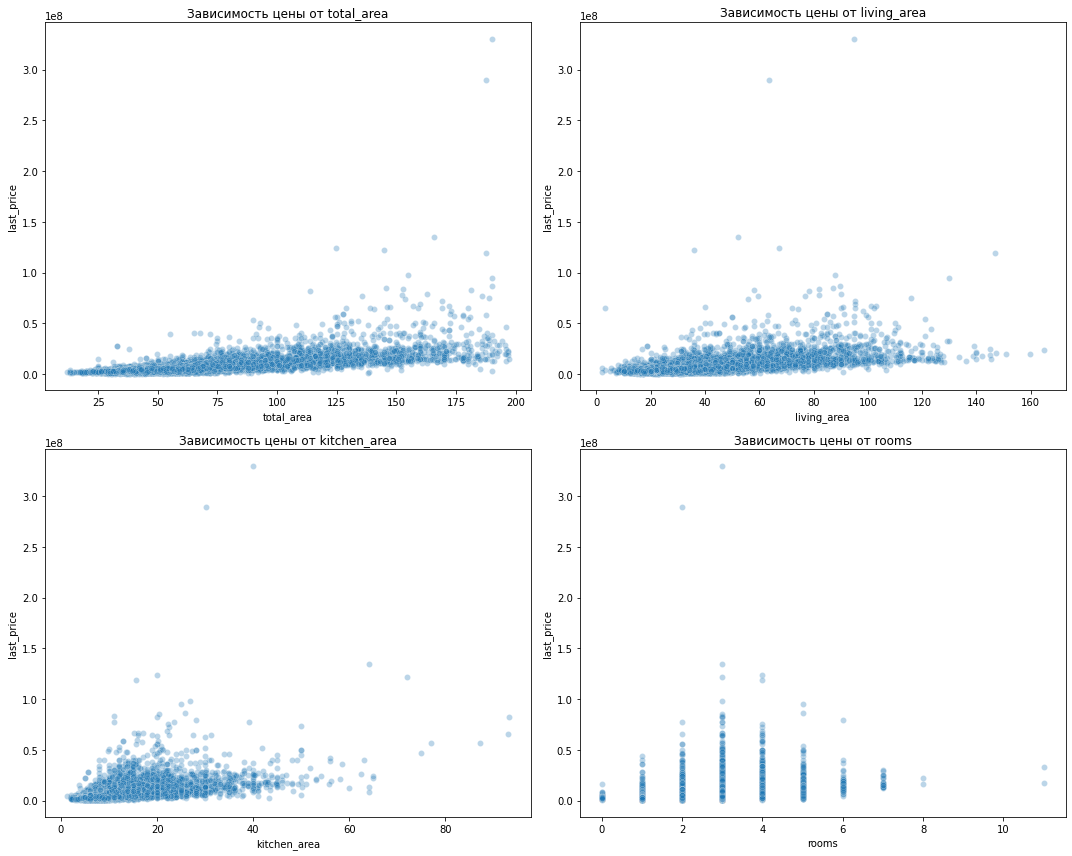

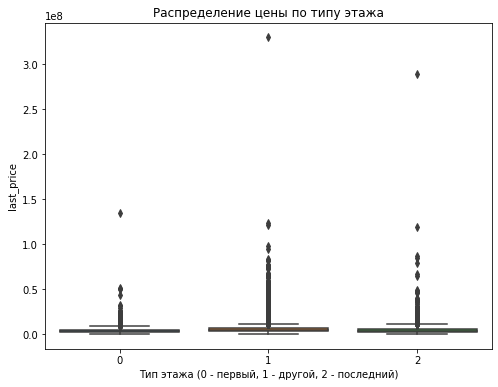

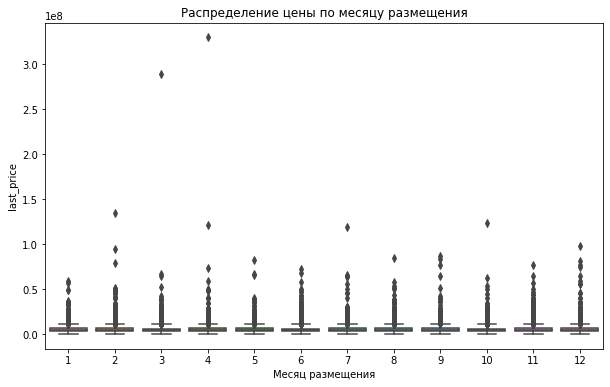

In [35]:
# Определяем параметры для визуализации
features = ['total_area', 'living_area', 'kitchen_area', 'rooms']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Создаём сетку графиков
axes = axes.flatten()

# Строим scatterplot для непрерывных переменных
for i, feature in enumerate(features):
    sns.scatterplot(data=data, x=feature, y='last_price', alpha=0.3, ax=axes[i])
    axes[i].set_title(f'Зависимость цены от {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('last_price')

plt.tight_layout()
plt.show()

# Boxplot для категориального признака "тип этажа"
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='floor_type_encoded', y='last_price')
plt.title('Распределение цены по типу этажа')
plt.xlabel('Тип этажа (0 - первый, 1 - другой, 2 - последний)')
plt.ylabel('last_price')
plt.show()

# Boxplot для месяца размещения объявления
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='exposition_month', y='last_price')
plt.title('Распределение цены по месяцу размещения')
plt.xlabel('Месяц размещения')
plt.ylabel('last_price')
plt.show()


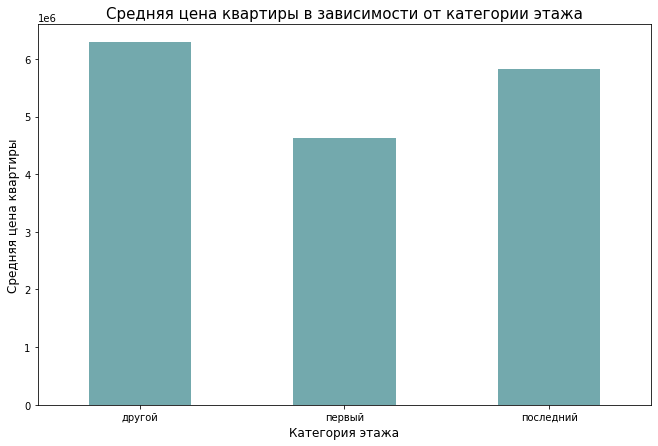

In [ ]:
# код

data.groupby('floor_type')['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от категории этажа', size=15)
plt.xlabel('Категория этажа', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

Выводы по влиянию факторов на стоимость:
Общая площадь (total_area) — 0.66. Это самый сильный фактор: чем больше площадь, тем дороже квартира.
Жилая площадь (living_area) — 0.55. Также имеет значительное влияние, но слабее, чем общая площадь.
Площадь кухни (kitchen_area) — 0.54. Важный фактор, особенно для больших квартир.
Количество комнат (rooms) — 0.38. Количество комнат влияет, но слабее, чем площадь
Тип этажа (floor_type_encoded) — 0.045. Очень слабая корреляция, почти не влияет на цену.

Анализ графиков:

Зависимость цены от площади:
Общая площадь (total_area) показывает наибольшую корреляцию с ценой. Видно, что с увеличением площади стоимость также возрастает, хотя есть выбросы, особенно в диапазоне больших площадей.

Жилая площадь (living_area) и площадь кухни (kitchen_area) также имеют положительную зависимость от цены, но связь менее выражена по сравнению с общей площадью.

Количество комнат (rooms) демонстрирует слабую зависимость, так как цена растет не строго линейно с увеличением числа комнат. Возможны случаи небольших дорогих квартир с малым числом комнат.

Распределение цены по типу этажа:
Тип этажа (первый, другой, последний) практически не оказывает значимого влияния на цену.
Наблюдаются выбросы (очень дорогие квартиры) во всех категориях, но медиана стоимости остается примерно одинаковой.

Распределение цены по месяцу размещения:
Явных сезонных колебаний в цене не наблюдается, что подтверждается низким коэффициентом корреляции.
Выбросы присутствуют в разных месяцах, но медианы цен остаются стабильными.

Выводы:
Общая площадь — ключевой фактор, влияющий на цену. Жилая площадь и площадь кухни также значимы, но в меньшей степени. Количество комнат влияет на цену, но слабее, чем площадь. Вероятно, ценность определяется функциональностью, а не просто числом комнат. Тип этажа почти не влияет на цену. Возможно, другие характеристики (расположение, инфраструктура) оказывают большее влияние. Сезонность размещения объявлений не оказывает значительного влияния на цену. Цены остаются стабильными в течение года.

In [37]:
# Выполним анализ средней цены квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
# Группируем по населенным пунктам и считаем количество объявлений
top_localities = data['locality_name'].value_counts().head(10).index

# Фильтруем данные по этим населённым пунктам
top_data = data[data['locality_name'].isin(top_localities)]

# Считаем среднюю цену за квадратный метр для каждого населённого пункта
price_per_sqm = top_data.groupby('locality_name')['price_per_sq_m'].mean().sort_values(ascending=False)

# Вывод результатов
print(price_per_sqm)


locality_name
санкт-петербург      113562.054344
пушкин               103122.538929
деревня кудрово       92473.547559
посёлок парголово     90332.262638
посёлок мурино        86018.851173
посёлок шушары        78551.344647
колпино               75333.295816
гатчина               68746.146515
всеволожск            68654.473970
выборг                58141.909325
Name: price_per_sq_m, dtype: float64


Выводы:
Самая высокая стоимость квадратного метра — в Санкт-Петербурге.
Самая низкая стоимость квадратного метра — в Выборге.

In [38]:
# Выполним анализ зависимости средней стоимости квартир от расстояния до центра Санкт-Петербурга
# Убедимся, как название города Санкт-Петербург записано в данных 
print(data['locality_name'].unique())

['санкт-петербург' 'посёлок шушары' 'посёлок янино-1' 'посёлок парголово'
 'посёлок мурино' 'ломоносов' 'сертолово' 'петергоф' 'пушкин'
 'деревня кудрово' 'коммунар' 'колпино'
 'поселок городского типа красный бор' 'гатчина' 'деревня фёдоровское'
 'выборг' 'кронштадт' 'кировск' 'деревня новое девяткино'
 'посёлок металлострой' 'посёлок городского типа лебяжье'
 'посёлок городского типа сиверский' 'поселок молодцово'
 'поселок городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк'
 'деревня куттузи' 'посёлок аннино' 'поселок городского типа ефимовский'
 'посёлок плодовое' 'деревня заклинье' 'поселок торковичи'
 'поселок первомайское' 'красное село' 'посёлок понтонный' 'сясьстрой'
 'деревня старая' 'деревня лесколово' 'посёлок новый свет' 'сланцы'
 'село путилово' 'ивангород' 'шлиссельбург' 'никольское' 'зеленогорск'
 'сосновый бор' 'поселок новый свет' 'деревня оржицы' 'деревня кальтин

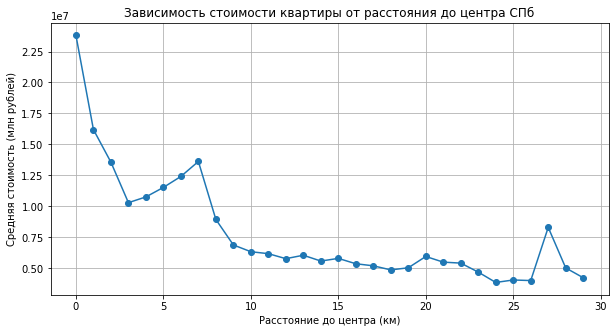

In [39]:
# Фильтруем только квартиры в Санкт-Петербурге
spb_flats = data[data['locality_name'] == 'санкт-петербург']

# Группируем по километрам и считаем среднюю цену
# Округлим расстояние cityCenters_nearest_km до целого числа и посчитаем среднюю цену для каждой группы.
price_by_distance = spb_flats.groupby('cityCenters_nearest_km')['last_price'].mean()

# Визуализация данных
plt.figure(figsize=(10, 5))
plt.plot(price_by_distance.index, price_by_distance.values, marker='o', linestyle='-')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя стоимость (млн рублей)')
plt.title('Зависимость стоимости квартиры от расстояния до центра СПб')
plt.grid()
plt.show()


Судя по графику, можно заметить несколько интересных трендов:
Вблизи центра (до 3 км) цена значительно выше, но наблюдаются резкие скачки в районе 6-7 км.
После 9 км цены становятся стабильнее и идут на снижение.
Есть аномальные пики в районе 27-30 км, возможно, что это элитные загородные ЖК или просто выбросы.

### Напишите общий вывод

Вывод по исследовательскому анализу данных о недвижимости Санкт-Петербурга и параметров, влияющих на цену:

Влияние расстояния до центра

Самые дорогие квартиры расположены в пределах 2-3 км от центра.
После 8-9 км цены становятся стабильнее и идут на снижение.
Есть выбросы в районе 27 км, возможно, элитные загородные ЖК.
Факторы, влияющие на стоимость квартиры:
Общая площадь - ключевой фактор: чем больше, тем дороже.
Жилая площадь - важный, но слабее общего метража.
Площадь кухни - особенно значима для больших квартир.
Количество комнат - влияет, но не так сильно, как площадь.
Этаж - слабая корреляция, почти не влияет.

Распределение цен и характеристик квартир:

Большинство квартир среднего размера (50–60 м²), основная масса до 100 м².
Стандартные кухни около 12 м², редкие выбросы 40+ м² (элитная недвижимость).
Основная масса квартир до 10 млн рублей, средняя цена ~6 млн рублей.
Встречаются цены до 300 млн - это элитные объекты.

По комнатам: преобладают 1–3-комнатные квартиры.

Дополнительные наблюдения:

Типичная квартира: 2-3 комнаты, 50-60 м², кухня ~10 м², в пределах 10-20 км от центра.
Потолки в основном 2.6–2.7 м, но встречаются выбросы 4+ м (лофты, старый фонд).
Большинство домов 5–16 этажей (старый фонд и новостройки).
Основная часть квартир в пределах 15 км от центра, встречаются до 60 км (загородка).
Близость к паркам: большинство квартир в пределах 1 км, удаленность от парков 3 км - районы без зелени.
Данные демонстрируют сильную асимметрию, особенно по цене, площади и расстоянию.

Заключение:

Разброс цен большой, но главные тренды подтверждают, что цена падает с увеличением расстояния до центра, а элитное жилье сильно выделяется по характеристикам. 

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.